# Group Exam INFO 284

## Importing libraries

The following imports are requiered

In [ ]:
# Standard libraries
import ast
from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
from PIL import Image

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Machine Learning - Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    median_absolute_error,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

# Machine Learning - XGBoost
import xgboost as xgb

# Deep Learning - TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input


## Task 1: Sentiment Analysis

### Fetching data

In [11]:
data=pd.read_csv('Hotel_Reviews.csv') #read the csv file

### Data analysis

This is the data analysis part. We have decided to split the reviews beetween positive and negative review. Any review score greater or equal to 5, we classify as a positive review, and the rest as negative review. Our goal is to try to find what data points have little correlation on whether the review score is positive or negative. Currently we have not used the result of this analysis yet, but it will be used in our final draft. 

In [ ]:
# Preparing data for analysis
# This cell is a bit slow to run, so it is intended to be run only once

# The next part of the code aims to split the 'Tags' column into multiple columns

data['Tags'] = data['Tags'].apply(ast.literal_eval) # Convert the string to a list, This code is made by chatgpt

# The following 3 lines of code is made by github copilot

tags_expanded = data['Tags'].apply(pd.Series) # Expand the 'Tags' column into multiple columns

tags_expanded.columns = [f'Tag_{i}' for i in range(tags_expanded.shape[1])] # Rename the columns for better readability

data = pd.concat([data, tags_expanded], axis=1) # Concatenate the expanded tags with the original dataframe

data.drop('Tags',axis=1,inplace=True)   # Drop the column 'Tags' due to the data being split into multiple columns

# The next part of the code turns the 'days_since_review' and 'Tag_3' columns into integers
data['days_since_review']=data['days_since_review'].str.extract('(\d+)').astype(int) # Extract the number from the string. This code if made using chatgpt
data['Tag_3'] = data['Tag_3'].str.extract('(\d+)').astype(float) # Extract the number from the string and convert to float. For some reason it did not work as int

# Label encode non-numerical features

label_encoded_hotel_address = LabelEncoder()
data['Hotel_Address'] = label_encoded_hotel_address.fit_transform(data['Hotel_Address'])

label_encoded_hotel_name = LabelEncoder()
data['Hotel_Name'] = label_encoded_hotel_address.fit_transform(data['Hotel_Name'])

label_encoded_reviwer_nationality = LabelEncoder()
data['Reviewer_Nationality'] = label_encoded_reviwer_nationality.fit_transform(data['Reviewer_Nationality'])

# # The next part of the code creates a new dataframe with hotel names and removes it from the dataframe data
# hotel_names = data['Hotel_Name'] # Create a new dataframe with the hotel names
# data.drop('Hotel_Name',axis=1,inplace=True) # Drop the column 'Hotel_Name' as it is not needed in the model

NameError: name 'data' is not defined

#### Plot of correlation matrix in order to see which numerical features can be dropped.

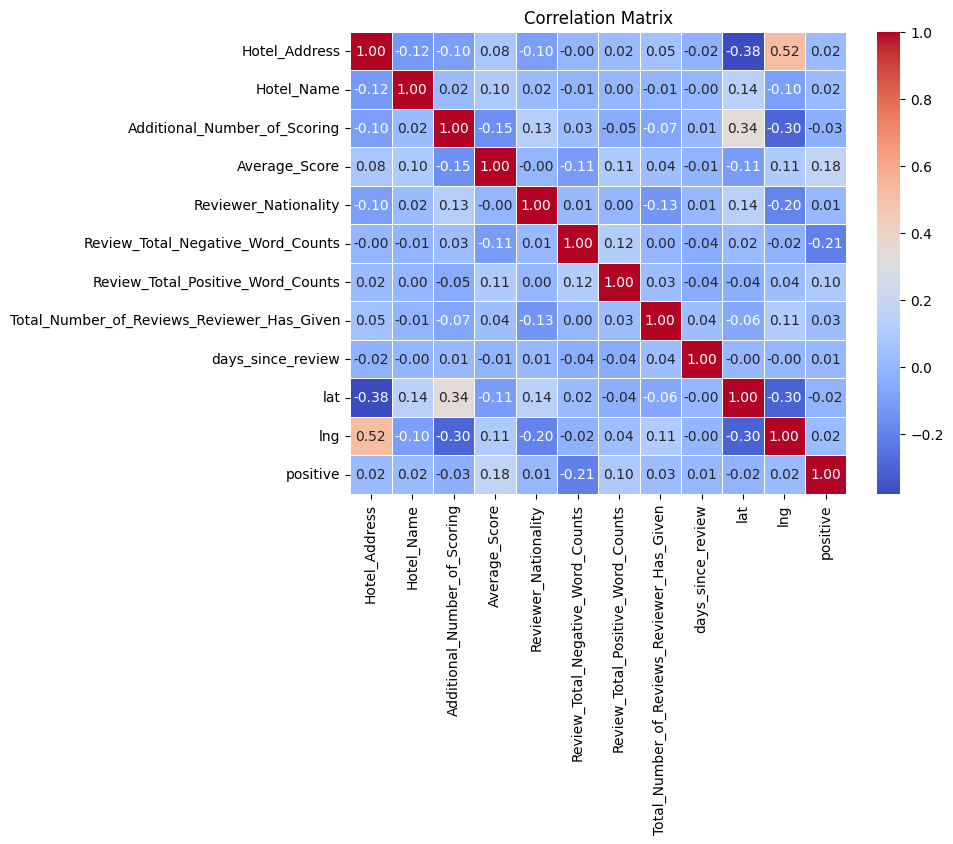

In [ ]:
# binary variable to determine sentiment (1 if Reviewer_Score >= 5, else 0)
data['positive'] = (data['Reviewer_Score'] >= 5).astype(int)

numerical_data = data[['Hotel_Address', 'Hotel_Name','Additional_Number_of_Scoring', 'Average_Score', 'Reviewer_Nationality', 'Review_Total_Negative_Word_Counts',
                            'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given',
                            'days_since_review', 'lat', 'lng', 'positive']]

# Compute correlation matrix
correlation_matrix = numerical_data.corr()

# Visualize the correlation matrix using a heatmap (ChatGPT)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

We drop any feature that has a near-zero correlation with sentiment. Additionally, we assume that Review_Date has no correlation with sentiment.

In [ ]:
# Dropping irrelevant features
data.drop('Hotel_Address',axis=1,inplace=True)  
data.drop('Hotel_Name',axis=1,inplace=True)  
data.drop('Review_Date',axis=1,inplace=True)    
data.drop('Additional_Number_of_Scoring',axis=1,inplace=True)  
data.drop('lat',axis=1,inplace=True)    
data.drop('lng',axis=1,inplace=True)    
data.drop('Total_Number_of_Reviews',axis=1,inplace=True)   
data.drop('Total_Number_of_Reviews_Reviewer_Has_Given',axis=1,inplace=True)
data.drop('days_since_review',axis=1,inplace=True)  
data.drop('Reviewer_Nationality',axis=1,inplace=True)  

In [ ]:
# Used for plotting the amount of positive and negative reviews

# convert reviewer score to binary labels (positive or negative review)
sentiment = (data['Reviewer_Score'] >= 5).astype(int)

positive_count = np.sum(sentiment == 1)
negative_count = np.sum(sentiment == 0)

categories = ['Negative', 'Positive']
counts = [negative_count, positive_count]

plt.bar(categories, counts, color=['red', 'green'])
plt.xlabel("Review Sentiment")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Sentiments")

plt.show()
print(Counter(data['positive'])) # finding ratio of positive to negative reviews

Dealing with the imbalance
The issue
When setting the threshold at 5, we get an extremely umbalanced target variable. ~95% of reviews have a reviewer score of 5 or higher. This means that the models can achieve 95% accuracy by guessing that every review is positive.

Methods
There are multiple ways of dealing with imbalance. The most common methods are

Resampling (over/undersampling)
Oversampling: Include more of the minority class
Might cause overfitting
Undersampling: Include less of the majority class
Lower risk of overfitting, but information is lost
Class weights
Assign a weight to the classes that punishes predicting negative reviews as positive
Good for binary classification
Focal loss
Focuses learning on the minority class
Stratification
Ensures the ratio of positive and negative reviews remains constant when splitting the dataset

### Basic data cleaning

This is the basic data cleaning that should be the base part in each of the four models. Each model will do more data cleaning depending on whats relevant for their specific model.

Our current desicion is to remove the hotel identifiers for the model, but we might change that for the final draft.

In [ ]:
# This is the basic data cleaning process. This should be added in all the models
# This cell is a bit slow to run, so it is intended to be run only once

# This part drops the columns that are not needed in the model
data.drop('Hotel_Address',axis=1,inplace=True)  # Drop the column 'Hotel_Address' due to lack of relevance
data.drop('Review_Date',axis=1,inplace=True)    # Drop the column 'Review_Date' due to lack of complete data
data.drop('Additional_Number_of_Scoring',axis=1,inplace=True)  # Drop the column 'Additional_Number_of_Scoring' due to not knowing what the numbers mean
data.drop('lat',axis=1,inplace=True)    # Drop the column 'lat' due to lack of relevance
data.drop('lng',axis=1,inplace=True)    # Drop the column 'lng' due to lack of relevance
data.drop('Total_Number_of_Reviews',axis=1,inplace=True)    # Drop the column 'Total_Number_of_Reviews' due to the number seams to be incorrect


# The next part of the code aims to split the 'Tags' column into multiple columns

data['Tags'] = data['Tags'].apply(ast.literal_eval) # Convert the string to a list, This code is made by chatgpt

# The following 3 lines of code is made by github copilot

tags_expanded = data['Tags'].apply(pd.Series) # Expand the 'Tags' column into multiple columns

tags_expanded.columns = [f'Tag_{i}' for i in range(tags_expanded.shape[1])] # Rename the columns for better readability

data = pd.concat([data, tags_expanded], axis=1) # Concatenate the expanded tags with the original dataframe

data.drop('Tags',axis=1,inplace=True)   # Drop the column 'Tags' due to the data being split into multiple columns

# The next part of the code turns the 'days_since_review' and 'Tag_3' columns into integers
data['days_since_review']=data['days_since_review'].str.extract('(\d+)').astype(int) # Extract the number from the string. This code if made using chatgpt
data['Tag_3'] = data['Tag_3'].str.extract('(\d+)').astype(float) # Extract the number from the string and convert to float. For some reason it did not work as int

# The next part of the code creates a new dataframe with hotel names and removes it from the dataframe data
data.drop('Hotel_Name',axis=1,inplace=True) # Drop the column 'Hotel_Name' beacause we want to model to be able to be more generalized. 

### Model 1 XGB-Regressor

This is a model using a model from XGBoost(Extreme Gradient Boosting). This is a boosted decision-three. This model aims to try to predict the review-score without directly predicting the sentiment in the texts in positve and negative review.

In [13]:
xgb_data = data.copy() # Create a copy of the dataframe data
xgb_data.drop('Negative_Review',axis=1,inplace=True) # Drop the column 'Negative_Review' as it is not a numeric value
xgb_data.drop('Positive_Review',axis=1,inplace=True) # Drop the column 'Positive_Review' as it is not a numeric value

# One hot encode only the necessary columns
xgb_data = pd.get_dummies(xgb_data, columns=['Tag_0', 'Tag_1', 'Tag_2', 'Tag_4', 'Tag_5'], dtype=int)

# Label encode the 'Reviewer_Nationality' column
labelencoder = LabelEncoder()
xgb_data['Reviewer_Nationality'] = labelencoder.fit_transform(xgb_data['Reviewer_Nationality'])

# Turn the 'Reviewer_Score' column into a scale from 0-100 instead of 0-10
xgb_data['Reviewer_Score'] = xgb_data['Reviewer_Score'] * 10
xgb_data['Reviewer_Score']=xgb_data['Reviewer_Score'].astype(int) # Convert the 'Reviewer_Score' column to int

In [ ]:
# The next part of the code splits the data into training and testing data. 
# The target can of course be changed to a bin type if needed.
x = xgb_data.drop('Reviewer_Score',axis=1) # Define the features
y = xgb_data['Reviewer_Score'] # Define the target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=69, stratify=y) # Split the data into training and testing data test_size is big due to memory issues when training the model

The only change from last time is that the train-test split is stratified in order to try to balanse the data-set

Below is some data about the errors the model makes.

In [ ]:
xgb_model = xgb.XGBRegressor(tree_method='hist')#,max_depth=3,n_estimators=50,gamma=0.2,subsample=0.8,colsample_bytree=0.8, learning_rate=0.05) # Create the xgboost model. The parameters are designed to limit the memory usage
xgb_model.fit(x_train, y_train) # Fit the model to the training data

In [ ]:
guess=xgb_model.predict(x_test) # Make a guess on the testing data

In [ ]:
mse=mean_squared_error(y_test,guess) # Calculate the mean squared error
print(mse)

In [ ]:
mae=mean_absolute_error(y_test,guess) # Calculate the mean absolute error
print(mae)

In [ ]:
r2=r2_score(y_test,guess) # Calculate the r2 score
print(r2)

In [ ]:
mape=mean_absolute_percentage_error(y_test,guess) # Calculate the mean absolute percentage error
print(mape)

In [ ]:
medianae=median_absolute_error(y_test,guess) # Calculate the median absolute error
print(medianae)

In [ ]:
sns.boxplot(x=y_test-guess) # Create a boxplot of the data

### Model 2 KNN


In [ ]:
data.fillna(0, inplace=True)  # Replace Nan-values with 0

In [ ]:
knn_data = data.copy()

knn_data.drop(['Negative_Review', 'Positive_Review'], axis=1, inplace=True) # In this model, these categories can not be used because the length of words that can not be converted to dummies.


# Label encode non-numerical features. LabelEncoder is neccesary for the Kernel to not crash due to data overload. This will happend when too many unique values are created when converting categorical values to continous values.
# Do this for all categories:
label_encoded_reviwer_nationality = LabelEncoder()
knn_data['Reviewer_Nationality'] = label_encoded_reviwer_nationality.fit_transform(knn_data['Reviewer_Nationality'])

label_encoded_tag_0 = LabelEncoder()
knn_data['Tag_0'] = label_encoded_tag_0.fit_transform(knn_data['Tag_0'].astype(str))

label_encoded_tag_1 = LabelEncoder()
knn_data['Tag_1'] = label_encoded_tag_1.fit_transform(knn_data['Tag_1'].astype(str))

label_encoded_tag_2 = LabelEncoder()
knn_data['Tag_2'] = label_encoded_tag_2.fit_transform(knn_data['Tag_2'].astype(str))

label_encoded_tag_3 = LabelEncoder()
knn_data['Tag_3'] = label_encoded_tag_3.fit_transform(knn_data['Tag_3'].astype(str))

label_encoded_tag_4 = LabelEncoder()
knn_data['Tag_4'] = label_encoded_tag_4.fit_transform(knn_data['Tag_4'].astype(str))

label_encoded_tag_5 = LabelEncoder()
knn_data['Tag_5'] = label_encoded_tag_5.fit_transform(knn_data['Tag_5'].astype(str))

print(knn_data.head())

In [ ]:
print(knn_data.dtypes)
print(knn_data.select_dtypes(include=['object']).head())

In [ ]:
features = knn_data.columns.difference(['Average_Score'])  # Returns all data except Avrage Score, because this might be higly correlated to what we want to predict
scaler = MinMaxScaler()                                          
knn_data[features] = scaler.fit_transform(knn_data[features])  # Scale the columns from 0-1


X = knn_data.drop('Reviewer_Score', axis=1)     #Need to drop this column so the predited output is not the actual input
y = knn_data['Reviewer_Score'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=68) # Split the data in to train/test-set

knn = KNeighborsRegressor(n_neighbors=707)        # Use regression because the values are continuous
knn.fit(X_train, y_train)                      

y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)    #Distance from predicted value to actual value


print(f'KNN Modellens Nøyaktighet: {mse:.4f}')

In [ ]:
sns.boxplot(x=y_test-y_pred)

### LSTM model
#### How the model works
The memory cell is controlled by three gates

Input gate - controls information added to the cell
Forget gate - Determines what information is removed from the cell
Output gate - Controls information is output from the
The memory cell allows the model to retain long-term dependencies.

#### Target
To determine sentiment, a target variable "positive" is created. The target is 1 if reviewer_score >= 5, otherwise 0. The threshold is set to 5, as it seems like the natural tipping point between a positive and negative review. Setting the threshold to 5 leads to a high level of imbalance in the target variable, which is why stratify=y when splitting.

#### Tokenizing and padding
When tokenizing, we set a limit for how many unique words should be included. This means that only the MAX_VOCAB (5018) most used words will be included. The limit is set such that the words included cover 97.5% of all words in the dataset. In this case, the value used is roughly 6% of the amount of unique words. This indicated that most reviews include mostly the same words.

When padding, the max_len is set such that it covers 95% of all reviews.

#### Encoding
Labelencoding is used because it is less memory intensive than one hot encoding.

#### Stratification
By using stratification when splitting, we preserve the class ratios. This is especially important in this case, as the target variable is imbalanced.

We drop any feature that has a near-zero correlation with sentiment. Additionally, we assume that Review_Date has no correlation with sentiment.

In [ ]:
# Dropping irrelevant features
data.drop('Hotel_Address',axis=1,inplace=True)  
data.drop('Hotel_Name',axis=1,inplace=True)  
data.drop('Review_Date',axis=1,inplace=True)    
data.drop('Additional_Number_of_Scoring',axis=1,inplace=True)  
data.drop('lat',axis=1,inplace=True)    
data.drop('lng',axis=1,inplace=True)    
data.drop('Total_Number_of_Reviews',axis=1,inplace=True)   
data.drop('Total_Number_of_Reviews_Reviewer_Has_Given',axis=1,inplace=True)
data.drop('days_since_review',axis=1,inplace=True)  
data.drop('Reviewer_Nationality',axis=1,inplace=True) 

In [ ]:
# Denne cellen kan ignoreres. Brukes bare til å finne verdier for MAX_LEN og MAX_VOCAB

df = data.copy()

review_lengths = df["Review_Total_Negative_Word_Counts"] + df["Review_Total_Positive_Word_Counts"]

reviews = df["Negative_Review"] + df["Positive_Review"]

# tokenize the reviews and create a list of all words
all_words = [word for review in reviews for word in review.lower().split()]

# count the frequency of each word
word_counts = Counter(all_words)

# cumulative sum of word frequencies
sorted_word_counts = sorted(word_counts.values(), reverse=True)
cumulative_sum = np.cumsum(sorted_word_counts)
total_words = sum(sorted_word_counts)

# Find unique words by converting the list of tokens to a set
unique_words = set(all_words)


# plot the distribution of review lengths (number of tokens)
plt.hist(review_lengths, bins=10, edgecolor='black')
plt.title('Distribution of Review Lengths (Tokens)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

# printing relevant information
print(f"Max review length: {max(review_lengths)}")
print(f"Min review length: {min(review_lengths)}")
print(f"Average review length: {np.mean(review_lengths)}")
print(f"95th percentile review length: {np.percentile(review_lengths, 95)}")
print("\n")
print(f"Total number of unique words: {len(unique_words)}")

# finding ideal MAX_VOCAB 

desired_coverage = 97.5

for max_vocab in range(1, len(cumulative_sum) + 1):

    coverage = cumulative_sum[max_vocab - 1]  
    coverage_percentage = (coverage / total_words) * 100
    
    if coverage_percentage >= desired_coverage:
        print(f"max_vocab for {desired_coverage}% coverage: {max_vocab} words")
        break 

#### Data preprocessing

In [ ]:
stop_words = set(stopwords.words('english'))

data_lstm = data.copy()

# binary variable to determine sentiment (1 if Reviewer_Score >= 5, else 0)
data_lstm['positive'] = (data_lstm['Reviewer_Score'] >= 5).astype(int)

# text preprocessing
MAX_VOCAB = 5018 # 97.5% coverage
MAX_LEN = 106 # 95th percentile of tokens in review

data_lstm['Positive_Review'] = data_lstm['Positive_Review'].astype(str)
data_lstm['Negative_Review'] = data_lstm['Negative_Review'].astype(str)

# this function was made by ChatGPT
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

data_lstm['Positive_Review'] = data_lstm['Positive_Review'].apply(remove_stopwords)
data_lstm['Negative_Review'] = data_lstm['Negative_Review'].apply(remove_stopwords)

tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tok.fit_on_texts(data_lstm['Positive_Review'] + data_lstm['Negative_Review'])

# text to sequences
X_pos = tok.texts_to_sequences(data_lstm['Positive_Review'])
X_neg = tok.texts_to_sequences(data_lstm['Negative_Review'])

# pad sequences
X_pos = pad_sequences(X_pos, maxlen=MAX_LEN, padding='post', truncating='post')
X_neg = pad_sequences(X_neg, maxlen=MAX_LEN, padding='post', truncating='post')

# numerical variables
num_variables = ['Average_Score', 'Review_Total_Negative_Word_Counts',
                'Review_Total_Positive_Word_Counts']
scaler = StandardScaler()
X_num = scaler.fit_transform(data_lstm[num_variables])

tags = ['Tag_0', 'Tag_1', 'Tag_2', 'Tag_3', 'Tag_4', 'Tag_5']

for tag in tags:
    label_encoded_tags = LabelEncoder()
    data_lstm[tag] = label_encoded_tags.fit_transform(data_lstm[tag])  # tag -> integer labels

X_tags = data_lstm[tags].values  # -> NumPy array

# combine features
X = np.hstack((X_pos, X_neg, X_num, X_tags))
y = data_lstm['positive'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify = y because of high level of imbalance in positive and negative reviews

#### Building the model
In the following cell, we build the model.

First LSTM layer: 64 neurons,
Second LSTM layer: 32 neurons
Dense layer: 32 neurons in fully connected layer
Dropout layer: Randomly drop 20% of inputs during training. Low dropout level, as overfitting is near 0.
Output layer
Includes performance metrics accuracy and AUC

In [ ]:
# Build the LSTM model
model = Sequential([
    Embedding(MAX_VOCAB, 128, input_length=X_train.shape[1]),
    LSTM(64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.2), # low dropout as overfitting is near 0 anyway
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

#### Class weights
Class weights are used here to deal with the imbalanced target variable. By using class weights, the model punishes false positives more than false negatives, so that the model tries to correctly labeling the reviews, instead of labeling almost all of them as positive.

#### Calculating class weights
Using the compute_class_weight function from sklearn to calculate ideal class weight.

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)

class_weights_dict = dict(zip([0, 1], class_weights))

print(class_weights_dict)

In [ ]:
# Train model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test), class_weight=class_weights_dict)

#### Results
First we want to see the distribution of the predictions

In [ ]:
# Used for plotting the amount of positive and negative reviews predicted by the model

# get probabilies
y_pred_probs = model.predict(X_test)

# convert probabilities to binary labels (positive or negative review)
y_pred = (y_pred_probs >= 0.5).astype(int)

positive_count = np.sum(y_pred == 1)
negative_count = np.sum(y_pred == 0)

categories = ['Negative', 'Positive']
counts = [negative_count, positive_count]

plt.bar(categories, counts, color=['red', 'green'])
plt.xlabel("Review Sentiment")
plt.ylabel("Number of Predictions")
plt.title("Distribution of Predicted Sentiments")

plt.show()
print(counts)

Without class weights, the model predicted that nearly all reviews were positive, resulting in high accuracy scores, but this is not what we want.

After including class weights, we can see that there are more reviews being labled as negative than we would like to see. This is because the model punishes false positives more than false negatives. Changing the class weights might help with this issue.

#### Evaluating the model
The following cell is for evaluating the model

The most relevant metrics are accuracy, F1 score and ROC-AUC.

F1 score is relevant as false positives and false negatives are equally bad.
ROC-AUC score is relevant as it works well with high imbalances. The score being near 1 also indicates that the model works well across all thresholds.

In [ ]:
# This cell is for evaluating the model

test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
train_loss, train_accuracy, train_auc = model.evaluate(X_train, y_train)
print(f'Test accuracy: {test_accuracy:.2f}')
print(f'Train accuracy: {train_accuracy:.2f}')
print(f'Overfitting: {train_accuracy-test_accuracy:.2f}')

# Convert predicted probabilities to binary classification (positive or negative review)
y_pred_prob = model.predict(X_test)  
y_pred = (y_pred_prob >= 0.5).astype(int)  # 1 if probability >= 5, otherwise 0

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob) 

# Results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}') # How many predicted positives are actually positive
print(f'Recall: {recall:.2f}') # How many actual positive cases were correctly predicted
print(f'F1-Score: {f1:.2f}') # Balance betweet precision and recall
print(f'ROC-AUC: {roc_auc:.2f}') # Area under ROC curve (recall against false positive rate)

# Scores from 0-1, where higher scores = better performance

The precision being 1 means that all predicted positives are actually positive. The class weights make it so that the model won't label any negative reviews as positive. This might be affecting the accuracy of the model. Perhaps the class weights could be adjusted, as false positives are not necessarily worse than false negatives.

### Model 4 TF-IDF

In [ ]:
tfidf_data = pd.read_csv('data/Hotel_Reviews.csv')

#reviews = data["Positive_Review"]
reviews = tfidf_data["Negative_Review"]

tfidf_vectorizer = TfidfVectorizer(stop_words="english")

X = tfidf_vectorizer.fit_transform(reviews)
y = tfidf_data["Reviewer_Score"].map(lambda x: 0 if x < 5.0 else 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

## Task 2
This code was written while using github Copilot.

In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [ ]:
# Checking the shape of the data
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

In [ ]:
# Here are the classes from the CIFAR-10 dataset. Dog is index 5.
# Information about the classes can be found at https://www.cs.toronto.edu/~kriz/cifar.html
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
# Change the answer data to check if the answer is a dog or not
def dogify(y):
    for i in range(len(y)):
        if y[i] == 5:
            y[i] = 1
        else:
            y[i] = 0
    return y

In [ ]:
dogify(y_train)
dogify(y_test)

In [ ]:
# Figuring out the max value of the pixel values in the dataset
print("Max pixel value:", np.max(x_train))
print("Min pixel value:", np.min(x_train))

In [ ]:
# Normalizing the pixel values to be between 0 and 1
x_train = x_train/255
x_test = x_test/255

The CNN-model have several layers.
The input layer indicates the shape of the input. In this case pictures with 32x32 pixels with rbg-values.
The convonutional layer creates filters that is supposed to classify features. In this case the first convonutional
layer creates 32 filters for each 3x3 square, while the next 2 create 64 filters for each square. 
The stride length is 1 by default. The pooling layer looks at every value in a 2x2 square an 
gives the highest value. Here the stride length is 2, as the default is the same as the pooling value. 
The flatteneing layer changes the data to be 1 dimensional for the fully connected layers at the end.
The first layer have 64 neurons connected to the 2 neurons at the end.

The logic for adding more filters in the later convonutional layers are that the features detected in the later part of the model are more complex, while in the earlier part its easier features like edges or colour changes. 

In [ ]:
# Creating the CNN model
model= models.Sequential([
    Input(shape=(32, 32, 3)), # Input layer, shape found earlier
    layers.Conv2D(32, (3, 3), activation='relu'), # First convolutional layer
    layers.MaxPooling2D((2, 2)), # First pooling layer
    layers.Conv2D(64, (3, 3), activation='relu'), # Second convolutional layer
    layers.MaxPooling2D((2, 2)), # Second pooling layer
    layers.Conv2D(64, (3, 3), activation='relu'), # Third convolutional layer
    layers.Flatten(), # Flattening the data to feed into the dense layer
    layers.Dense(64, activation='relu'), # Dense layer with 64 neurons
    layers.Dense(2, activation='sigmoid') # Output layer with 2 neurons (dog or not dog)
])

This dataset is inbalanced. It has equal number of pictures of each category, but dog is only one of 10 the categories. This means that only one tenth of the pictures are of dogs.

In [ ]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train.flatten())
class_weights_dict = dict(zip([0, 1], class_weights))
print(class_weights_dict)

In [ ]:
model.compile(optimizer='adam',  
              loss='sparse_categorical_crossentropy', # This loss function worked better than 'binary_crossentropy'.
              metrics=['accuracy'])

# Train the model with class weights
training = model.fit(x_train, y_train, epochs=10,
           validation_data=(x_test, y_test),
           class_weight=class_weights_dict)

I used activation sigmoid with sparse_categorical_crossentropy as this is the combination that worked best during 
my testing. It is unclear as to why this proved to be the best combination. I tested several combination with softmax, sigmoid, sparse_categorical_crossentropy, binary_crossentropy, 1 neuron in the final layer and 2 neurons in the final layer.

In [ ]:
# Plotting the training and validation accuracy and loss
plt.plot(training.history['accuracy'], label='train accuracy')
plt.plot(training.history['val_accuracy'], label='test accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The flattenning of the train accuracy curve shows that 10 epochs is enough for this model

In [ ]:
# Predicting the test set
y_pred = model.predict(x_test)

In [ ]:
# Creating a confusion matrix
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
print("Confusion matrix:\n", cm)

In [ ]:
#Checking if the model can correctly identify a dog
def check_if_dog(file):
    dog=Image.open(file)
    plt.imshow(dog)
    dog = dog.convert("RGB")
    dog = dog.resize((32, 32))
    dog = np.array(dog)
    dog = dog/255
    dog = np.expand_dims(dog, axis=0)
    dog_pred = model.predict(dog)
    print("Is dog?", np.argmax(dog_pred, axis=1)[0])

In [ ]:
check_if_dog("Dog1.jpg")

# Group Exam INFO 284

## Importing libraries

The following imports are requiered
## Task 1: Sentiment Analysis

### Fetching data
### Data analysis

This is the data analysis part. We have decided to split the reviews beetween positive and negative review. Any review score greater or equal to 5, we classify as a positive review, and the rest as negative review. Our goal is to try to find what data points have little correlation on whether the review score is positive or negative. Currently we have not used the result of this analysis yet, but it will be used in our final draft. 
### Plot of correlation matrix in order to see which numerical features can be dropped.
We drop any feature that has a near-zero correlation with sentiment. Additionally, we assume that Review_Date has no correlation with sentiment.
Dealing with the imbalance
The issue
When setting the threshold at 5, we get an extremely umbalanced target variable. ~95% of reviews have a reviewer score of 5 or higher. This means that the models can achieve 95% accuracy by guessing that every review is positive.

Methods
There are multiple ways of dealing with imbalance. The most common methods are

Resampling (over/undersampling)
Oversampling: Include more of the minority class
Might cause overfitting
Undersampling: Include less of the majority class
Lower risk of overfitting, but information is lost
Class weights
Assign a weight to the classes that punishes predicting negative reviews as positive
Good for binary classification
Focal loss
Focuses learning on the minority class
Stratification
Ensures the ratio of positive and negative reviews remains constant when splitting the dataset
### Basic data cleaning

This is the basic data cleaning that should be the base part in each of the four models. Each model will do more data cleaning depending on whats relevant for their specific model.

Our current desicion is to remove the hotel identifiers for the model, but we might change that for the final draft.
### Model 1 XGB-Regressor

This is a model using a model from XGBoost(Extreme Gradient Boosting). This is a boosted decision-three. This model aims to try to predict the review-score without directly predicting the sentiment in the texts in positve and negative review.
The only change from last time is that the train-test split is stratified in order to try to balanse the data-set

Below is some data about the errors the model makes.
### Model 2 KNN

### LSTM model
### How the model works
The memory cell is controlled by three gates

Input gate - controls information added to the cell
Forget gate - Determines what information is removed from the cell
Output gate - Controls information is output from the
The memory cell allows the model to retain long-term dependencies.

## Target
To determine sentiment, a target variable "positive" is created. The target is 1 if reviewer_score >= 5, otherwise 0. The threshold is set to 5, as it seems like the natural tipping point between a positive and negative review. Setting the threshold to 5 leads to a high level of imbalance in the target variable, which is why stratify=y when splitting.

## Tokenizing and padding
When tokenizing, we set a limit for how many unique words should be included. This means that only the MAX_VOCAB (5018) most used words will be included. The limit is set such that the words included cover 97.5% of all words in the dataset. In this case, the value used is roughly 6% of the amount of unique words. This indicated that most reviews include mostly the same words.

When padding, the max_len is set such that it covers 95% of all reviews.

## Encoding
Labelencoding is used because it is less memory intensive than one hot encoding.

## Stratification
By using stratification when splitting, we preserve the class ratios. This is especially important in this case, as the target variable is imbalanced.
We drop any feature that has a near-zero correlation with sentiment. Additionally, we assume that Review_Date has no correlation with sentiment.
#### Data preprocessing
#### Building the model
In the following cell, we build the model.

First LSTM layer: 64 neurons,
Second LSTM layer: 32 neurons
Dense layer: 32 neurons in fully connected layer
Dropout layer: Randomly drop 20% of inputs during training. Low dropout level, as overfitting is near 0.
Output layer
Includes performance metrics accuracy and AUC
## Class weights
Class weights are used here to deal with the imbalanced target variable. By using class weights, the model punishes false positives more than false negatives, so that the model tries to correctly labeling the reviews, instead of labeling almost all of them as positive.

## Calculating class weights
Using the compute_class_weight function from sklearn to calculate ideal class weight.
#### Results
First we want to see the distribution of the predictions
Without class weights, the model predicted that nearly all reviews were positive, resulting in high accuracy scores, but this is not what we want.

After including class weights, we can see that there are more reviews being labled as negative than we would like to see. This is because the model punishes false positives more than false negatives. Changing the class weights might help with this issue.
#### Evaluating the model
The following cell is for evaluating the model

The most relevant metrics are accuracy, F1 score and ROC-AUC.

F1 score is relevant as false positives and false negatives are equally bad.
ROC-AUC score is relevant as it works well with high imbalances. The score being near 1 also indicates that the model works well across all thresholds.
The precision being 1 means that all predicted positives are actually positive. The class weights make it so that the model won't label any negative reviews as positive. This might be affecting the accuracy of the model. Perhaps the class weights could be adjusted, as false positives are not necessarily worse than false negatives.
### Model 4 TF-IDF
## Task 2
This code was written while using github Copilot.
The CNN-model have several layers.
The input layer indicates the shape of the input. In this case pictures with 32x32 pixels with rbg-values.
The convonutional layer creates filters that is supposed to classify features. In this case the first convonutional
layer creates 32 filters for each 3x3 square, while the next 2 create 64 filters for each square. 
The stride length is 1 by default. The pooling layer looks at every value in a 2x2 square an 
gives the highest value. Here the stride length is 2, as the default is the same as the pooling value. 
The flatteneing layer changes the data to be 1 dimensional for the fully connected layers at the end.
The first layer have 64 neurons connected to the 2 neurons at the end.

The logic for adding more filters in the later convonutional layers are that the features detected in the later part of the model are more complex, while in the earlier part its easier features like edges or colour changes. 
This dataset is inbalanced. It has equal number of pictures of each category, but dog is only one of 10 the categories. This means that only one tenth of the pictures are of dogs.
I used activation sigmoid with sparse_categorical_crossentropy as this is the combination that worked best during 
my testing. It is unclear as to why this proved to be the best combination. I tested several combination with softmax, sigmoid, sparse_categorical_crossentropy, binary_crossentropy, 1 neuron in the final layer and 2 neurons in the final layer.
The flattenning of the train accuracy curve shows that 10 epochs is enough for this model

